First, create a function that gets the Mutual Information score for each feature. Then, get rid of features with mi = 0 (or features that are uninformative)

In [406]:
%load_ext autoreload
%autoreload 2
from src.functions import preprocess, evaluate_model, get_mi, plot_mi, interaction_features, drop_zeromi, kmeans_cluster
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train, df_test = preprocess()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = get_mi(X, y)
mi_scores.sort_values(ascending=False)

OverallQual             0.570187
Neighborhood_encoded    0.480704
GrLivArea               0.480315
YearBuilt               0.375320
GarageCars              0.370844
                          ...   
RoofStyle__Other        0.000000
LotConfig__Other        0.000000
BldgType__TwnhsE        0.000000
Exterior2nd__BrkFace    0.000000
RoofStyle__Gambrel      0.000000
Length: 161, dtype: float64

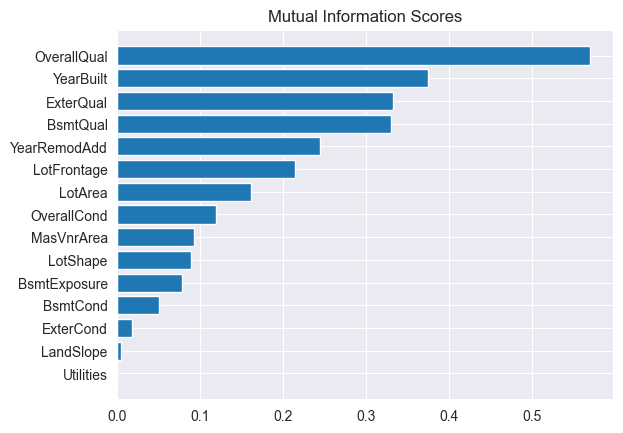

In [408]:
# plot top 15 scores
plot_mi(mi_scores.head(15));

In [409]:
mi_scores.sort_values(ascending=True)

LotConfig__FR2          0.000000
PoolQC                  0.000000
MiscFeature__Other      0.000000
MiscVal                 0.000000
MoSold                  0.000000
                          ...   
GarageCars              0.370844
YearBuilt               0.375320
GrLivArea               0.480315
Neighborhood_encoded    0.480704
OverallQual             0.570187
Length: 161, dtype: float64

Some features have a MI score of 0.0. It is better to drop those.

In [411]:
X = drop_zeromi(X, mi_scores)
X.shape

(1460, 138)

let's check the effect of dropping uninformative features

In [412]:
rmsle, mae = evaluate_model(X, y)

RMSLE: 0.13460
MAE: 17056.27558


# Next, create new features

Start with interaction/aggregate featuress

In [413]:
df_train, df_test = preprocess()

X = df_train.copy()
y = X.pop("SalePrice")

X = interaction_features(X)

mi_scores = get_mi(X, y)
X = drop_zeromi(X, mi_scores)

cols = ["TotalSF", "TotalBaths", "PorchSF", "BathsPerRoom", "PorchTypes", "Spaciousness", "LivLotRatio"]

# get mi scores for new features
X_cols = X[cols]
discrete = [X[c].nunique() <= 12 for c in cols]
mi = mutual_info_regression(X[cols], y, discrete_features=discrete, random_state=42)
mi_scores = pd.Series(mi, index=cols).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_scores)


Mutual Information Scores:
 TotalSF         0.661641
TotalBaths      0.337633
BathsPerRoom    0.325973
Spaciousness    0.248966
PorchTypes      0.112505
PorchSF         0.100326
LivLotRatio     0.086442
dtype: float64


In [414]:
rmsle, mae = evaluate_model(X, y)

RMSLE: 0.13781
MAE: 17221.58328


informative features: TotalSF, AgeAtSale, TotalBaths, BathsPerRoom

### Next, KMeans clustering features

In [415]:
df_train, df_test = preprocess()

cluster_features = [
    "TotalSF",        # holistic size measure
    "TotalBaths",     # overall bathrooms
    "BathsPerRoom",   # efficiency/use ratio
    "LotArea",        # land size (adds location/lot info)
    "OverallQual",    # overall quality
]# ]

X = df_train.copy()
y = X.pop("SalePrice")

X = interaction_features(X)

X = interaction_features(X)
X = kmeans_cluster(X, cluster_features, k=5)

print(X["Clusters"].value_counts())

# mi analysis
discrete = [X[c].nunique() <= 12 for c in X.columns]
mi = mutual_info_regression(X, y, discrete_features=discrete, random_state=42)
mi_scores = pd.Series(mi, index=X.columns)

X = drop_zeromi(X, mi_scores)

print("MI Score for Clusters:", mi_scores.Clusters)
rmsle, mae = evaluate_model(X, y)

Clusters
1    585
0    368
4    260
2    243
3      4
Name: count, dtype: int64
MI Score for Clusters: 0.5088044124708226
RMSLE: 0.13821
MAE: 17013.79217


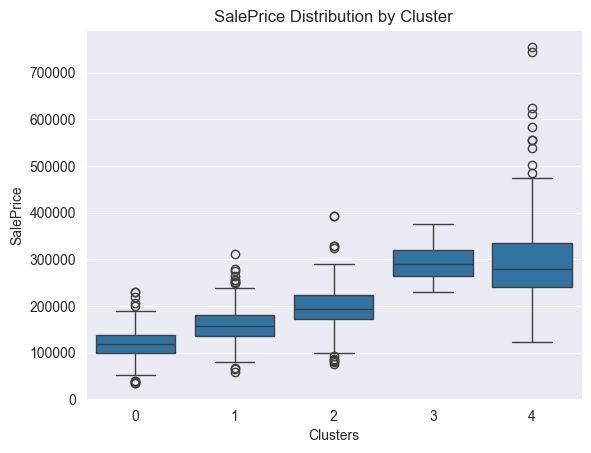

In [416]:
# Merge X and y for visualization only
plot_df = X.copy()
plot_df["SalePrice"] = y

sns.boxplot(data=plot_df, x="Clusters", y="SalePrice")
plt.title("SalePrice Distribution by Cluster")
plt.show()